# Tutorial 7 & 8 - Control 

Continuing from last tutorial, use the model with the fixed flow. We are now going to implement DO control using a P/PI controller.


Here is an example of P control:

    DO_sp_x = 2                             # your target DO setpoint in reactor x
    kLa_x = 0                               # inintal kLa - i.e. controller not oprating 
    DO_x = yv[7,x]                          # DO in reactor x  
    DO_error_x = DO_sp_x-DO_x               # Error   
    kp_x = 10                               # Proportinonal term - you can tune this later 
    if DO_error_x > 0:                      # only activate the controller if the error is positive,
        kLa2= kp_DO_error_x                 # calulate the kLa based on the error and gain 
    


(a) Implement a P controller in your model and plot your DO over time? How do you decrease the final error using the P controller?


   


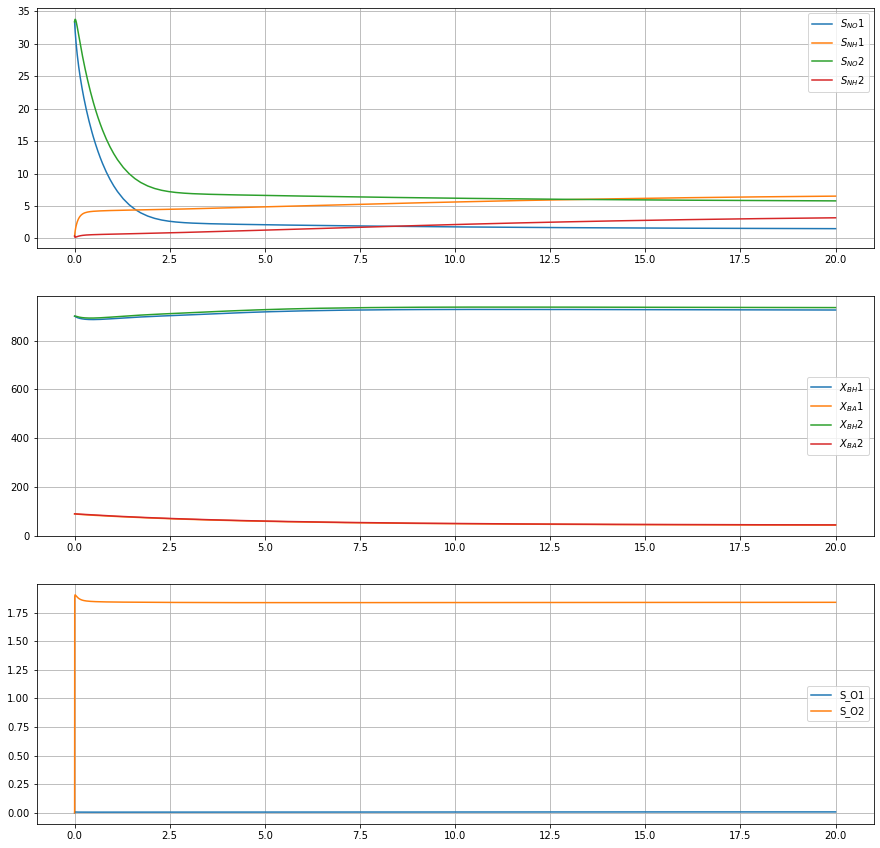

In [33]:
%reset -f

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def asm1_2_comp(t,y):

    # Define number of compartments
    n = 2

    # indexes i=states, j=procs, k=compartment

    # Define state variables
    #                           0  1  2  3  4   5   6  7  8   9   10  11  12
    # state vector in order is: Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    
    # set up a vector shaped 13 (states) by n (compartments) 
    # this loops through the compartments to bulid the yv vector   
    yv = np.zeros((13,n))
    for k in range(n):
        ycurr=y[13*k:(k+1)*13]
        yv[:,k]=ycurr
    
    #Mean influent concentrations of components
    #      Si  Ss  Xi   Xs Xbh   Xba  Xp So Sno Snh   Snd   Xnd   Salk
    yin = [40, 64, 40, 160, 96, 0.001, 0, 0, 1, 12.5, 10.1, 18.28, 6]

    #Plant defintion and operational parameters
    V       = [50,30]          # volume (m3)
    qin     = 100              # influent flow rate (m3/d)
    qr      = 5*qin            # internal recycle
    qs      = qin              # clarifier underflow
    qw      = qin/20            # sludge wasteage flow
    qout    = qin-qw           # final outflow
    Xout    = 10               # final concentration solids

    #%% Parameters
    Ya  = 0.24                 # yield autotrophs
    Yh  = 0.67                 # yield heterotrophs
    fp  = 0.08                 # biomass to particulate products
    ixb = 0.07                 # N in biomass
    ixp = 0.06                 # N in particulate from biomass
    # Heterotrophs & hydrolysis
    muh = 4
    Ks  = 20
    Koh = 0.2
    Kno = 0.5
    bh  = 0.5
    nug = 0.8
    nuh = 0.35
    kh  = 1.5
    Kx  = 0.02
    # Autotrophs & ammonification
    mua = 0.9
    Knh = 0.75
    Koa = 0.5
    ka  = 0.08
    ba  = 0.1
    # Oxygen transfer
    O_sat = 7
    
    #%% Controls
    # Control for compartment 2
    DO_sp = 2
    kLa2 = 0
    error2 = DO_sp-yv[7,1]
    kp2 = 1000
    if error2>0:
        kLa2= kp2*error2 


    #%% Stoichiometry
    v = np.zeros((9,13))
    v[0,1]  = (-1/Yh)
    v[0,4]  = 1
    v[0,7]  = -(1-Yh)/Yh       # Add DO coefficent for Hererotrophic growth
    v[0,9] = -ixb
    v[0,12] = (-ixb/14)

    v[1,1]  = (-1/Yh)
    v[1,4]  = 1
    v[1,8]  = (-(1-Yh)/(2.86*Yh))
    v[1,9] = -ixb
    v[1,12] = (((1-Yh)/(14*2.86*Yh))-ixb/14)

    v[2,5]  = 1    
    v[2,7]  = -(4.57-Ya)/Ya    # Add DO coefficent for Autotrophic growth
    v[2,8]  = 1/Ya
    v[2,9] = -ixb-1/Ya
    v[2,12] = (-ixb/14-1/(7*Ya))

    v[3,3]  = 1-fp
    v[3,4]  = -1
    v[3,6]  = fp
    v[3,11] = ixb-fp*ixp

    v[4,3]  = 1-fp
    v[4,5]  = -1
    v[4,6]  = fp
    v[4,11] = ixb-fp*ixp

    v[5,9] = 1
    v[5,10] = -1
    v[5,12] = 1/14

    v[6,1]  = 1
    v[6,3]  = -1

    v[7,10] = 1
    v[7,11] = -1
    
    v[8,7]  = 1                # Add Coeff for aeration

    
    #%% Process rates (constitutive equations)
    #    Si; Ss; Xi; Xs; Xbh; Xba; Xp ;So;Sno ;Snh;Snd; Xnd;Salk
    #    0   1   2   3   4    5    6   7   8   9   10    11  12 
    r=np.zeros((9,n))
    for i in range(n):
        r[0,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(yv[7,i]/(Koh+yv[7,i]))*yv[4,i]
        r[1,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+(yv[8,i])))*nug*yv[4,i]
        r[2,i] = mua*(yv[9,i]/(Knh+yv[9,i]))*(yv[7,i]/(Koa+yv[7,i]))*yv[5,i]
        r[3,i] = bh*yv[4,i]
        r[4,i] = ba*yv[5,i]
        r[5,i] = ka*yv[10,i]*yv[4,i]
        r[6,i] = kh*((yv[3,i]/yv[4,i])/(Kx+(yv[3,i]/yv[4,i])))*((yv[7,i]/(Koh+yv[7,i])) \
            +nuh*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+yv[8,i])))*yv[4,i]
        r[7,i] = r[6,i]*(yv[11,i]/yv[3,i])

    # set areation for comparment 2
    r[8,0] = 0  
    r[8,1] = kLa2*(O_sat-yv[7,1])  
    
    
    # Calculate clarifier capture 
    TS_end  = sum(yv[2:6,-1])
    qclar   = qin+qs-qw
    clarcap = 1-Xout*qout/(qclar*TS_end)
        
    # Calculate concentrations in sludge
    ys     = np.copy(yv[:,-1])         #initially set it to solubles
    ys[2]  = yv[2,-1] *(qin+qs-qw)/qs*clarcap
    ys[3]  = yv[3,-1] *(qin+qs-qw)/qs*clarcap
    ys[4]  = yv[4,-1] *(qin+qs-qw)/qs*clarcap
    ys[5]  = yv[5,-1] *(qin+qs-qw)/qs*clarcap
    ys[6]  = yv[6,-1] *(qin+qs-qw)/qs*clarcap
    ys[11] = yv[11,-1]*(qin+qs-qw)/qs*clarcap
    
    #%% Mass balances in steady state (conservative equations)
    #    Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    #    0  1  2  3   4  5   6  7   8   9  10  11   12 
    # First compartment
    dydtv = np.zeros((13,n))
    for i in range(13):
        dydtv[i,0] = 1/V[0]*(qin*(yin[i]-yv[i,0]) \
                    + qr*(yv[i,-1]-yv[i,0]) \
                    + (qs-qw)*(ys[i]-yv[i,0])) \
                    + np.matmul(r[:,0],v[:,i])

    # Remaining compartments
    if n>1:
        for k in range(1,n):
            for i in range(13):
                dydtv[i,k] = 1/V[k]*((qin+qr+qs-qw)*(yv[i,k-1]-yv[i,k])) \
                    +np.matmul(r[:,k],v[:,i])

    # Demultiplex
    dydt=np.zeros_like(y)
    for k in range(n):
        dydtcurr = dydtv[:,k]
        dydt[k*13:13*(k+1)] = dydtcurr

    return dydt

# Initial conditions for states
Si0   = 40                  # soluble inerts (mg/L)
Ss0   = 2.62                # soluble (readily biodegradable) COD (mg/L)
Xi0   = 1000                # particulate inerts (mg/L)
Xs0   = 29.46               # particulate (slowly biodegradable) COD (mg/L)
Xbh0  = 900                 # active heterotrophic biomass (mg/L)
Xba0  = 90.39               # active autotrophic biomass (mg/L)
Xp0   = 100.08              # particulate COD from decay (mg/L)
So0   = 0
Sno0  = 33.31               # nitrate-N + nitrite-N (mg/L)
Snh0  = 0.41                # ammonia-N (mg/L)
Snd0  = 0.93                # soluble (readily biodegradable) organic nitrogen (mg/L)
Xnd0  = 2.54                # particulate (slowly biodegradable) organic nitrogen (mg/L)
Salk0 = 22.83               # alkalinity (M)

y0 = np.array([Si0,Ss0,Xi0,Xs0,Xbh0,Xba0,Xp0,So0,Sno0,Snh0,Snd0,Xnd0,Salk0])
y0 = np.hstack([y0,y0])
tspan = (0,20)
sol=solve_ivp(asm1_2_comp,tspan,y0,method='LSODA',)

fig,ax = plt.subplots(3,1,figsize=(15, 15))
ax[0].plot(sol.t,sol.y[8,:],sol.t,sol.y[9,:],
        sol.t,sol.y[21,:],sol.t,sol.y[22,:])
ax[0].grid() 
ax[0].legend(('$S_{NO}1$','$S_{NH}1$','$S_{NO}2$','$S_{NH}2$'))
ax[1].plot(sol.t,sol.y[4,:],sol.t,sol.y[5,:],
        sol.t,sol.y[17,:],sol.t,sol.y[18,:])
ax[1].legend(('$X_{BH}1$','$X_{BA}1$','$X_{BH}2$','$X_{BA}2$'))
ax[1].grid() 
ax[2].plot(sol.t, sol.y[7,:], sol.t, sol.y[20,:])
ax[2].legend(('S_O1','S_O2'))
ax[2].grid() 

(b) To implement the PI we need to integrate error over time, hence we need to create the integrator:

    dydt[13*n] = error_x
This puts the integrator into the last element of hte dydt array. Don’t forget to set an initial condition for the error.
Now change the code so that you have PI control. 

    kLa_x_= kp_x * error_x + ki_x * y[13*n]
where ki_x is the integrator gain.

Plot the results again, and observe how the integrator removes the error.


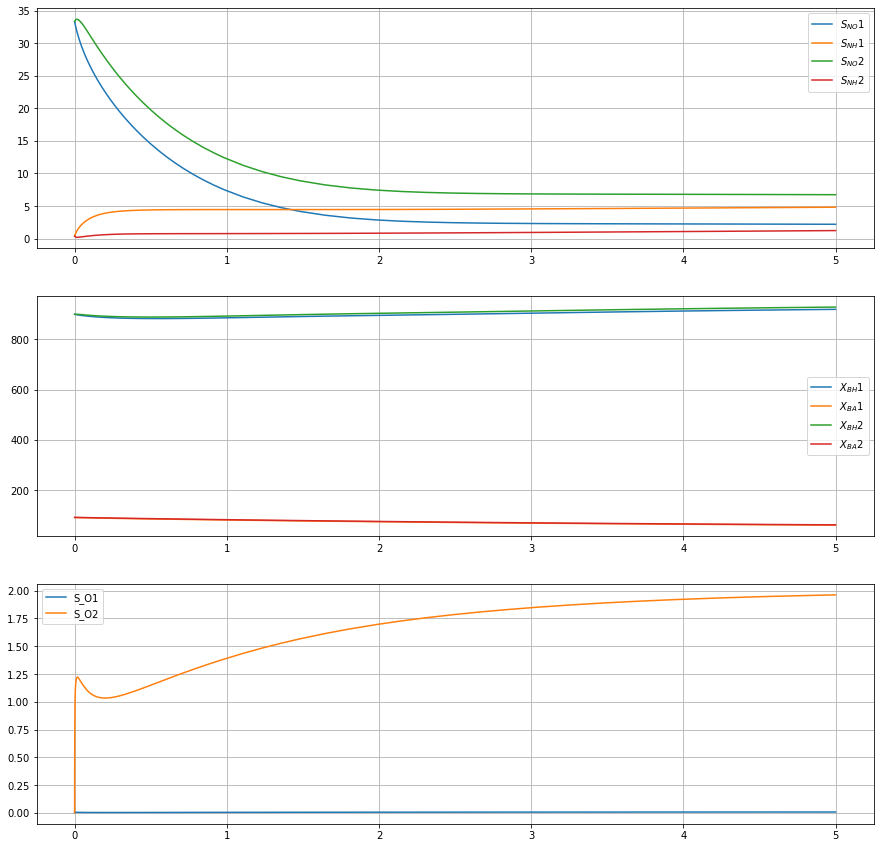

In [1]:
%reset -f

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def asm1_2_comp_PI(t,y):

    # Define number of compartments
    n = 2

    # indexes i=states, j=procs, k=compartment

    # Define state variables
    #                           0  1  2  3  4   5   6  7  8   9   10  11  12
    # state vector in order is: Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    
    # set up a vector shaped 13 (states) by n (compartments) 
    # this loops through the compartments to bulid the yv vector   
    yv = np.zeros((13,n))
    for k in range(n):
        ycurr=y[13*k:(k+1)*13]
        yv[:,k]=ycurr
    
    #Mean influent concentrations of components
    #      Si  Ss  Xi   Xs Xbh   Xba  Xp So Sno Snh   Snd   Xnd   Salk
    yin = [40, 64, 40, 160, 96, 0.001, 0, 0, 1, 12.5, 10.1, 18.28, 6]

    #Plant defintion and operational parameters
    V       = [50,30]          # volume (m3)
    qin     = 100              # influent flow rate (m3/d)
    qr      = 5*qin            # internal recycle
    qs      = qin              # clarifier underflow
    qw      = qin/20            # sludge wasteage flow
    qout    = qin-qw           # final outflow
    Xout    = 10               # final concentration solids

    #%% Parameters
    Ya  = 0.24                 # yield autotrophs
    Yh  = 0.67                 # yield heterotrophs
    fp  = 0.08                 # biomass to particulate products
    ixb = 0.07                 # N in biomass
    ixp = 0.06                 # N in particulate from biomass
    # Heterotrophs & hydrolysis
    muh = 4
    Ks  = 20
    Koh = 0.2
    Kno = 0.5
    bh  = 0.5
    nug = 0.8
    nuh = 0.35
    kh  = 1.5
    Kx  = 0.02
    # Autotrophs & ammonification
    mua = 0.9
    Knh = 0.75
    Koa = 0.5
    ka  = 0.08
    ba  = 0.1
    # Oxygen transfer
    O_sat = 7
    
    #%% Controls
    # Control for compartment 2
    DO_sp = 2
    kLa2 = 0
    error2 = DO_sp-yv[7,1]
    kp2 = 100
    ki2 = 100
    if error2>0:
        kLa2= kp2*error2 + ki2 * y[13*n]


    #%% Stoichiometry
    v = np.zeros((9,13))
    v[0,1]  = (-1/Yh)
    v[0,4]  = 1
    v[0,7]  = -(1-Yh)/Yh       # Add DO coefficent for Hererotrophic growth
    v[0,9] = -ixb
    v[0,12] = (-ixb/14)

    v[1,1]  = (-1/Yh)
    v[1,4]  = 1
    v[1,8]  = (-(1-Yh)/(2.86*Yh))
    v[1,9] = -ixb
    v[1,12] = (((1-Yh)/(14*2.86*Yh))-ixb/14)

    v[2,5]  = 1    
    v[2,7]  = -(4.57-Ya)/Ya    # Add DO coefficent for Autotrophic growth
    v[2,8]  = 1/Ya
    v[2,9] = -ixb-1/Ya
    v[2,12] = (-ixb/14-1/(7*Ya))

    v[3,3]  = 1-fp
    v[3,4]  = -1
    v[3,6]  = fp
    v[3,11] = ixb-fp*ixp

    v[4,3]  = 1-fp
    v[4,5]  = -1
    v[4,6]  = fp
    v[4,11] = ixb-fp*ixp

    v[5,9] = 1
    v[5,10] = -1
    v[5,12] = 1/14

    v[6,1]  = 1
    v[6,3]  = -1

    v[7,10] = 1
    v[7,11] = -1
    
    v[8,7]  = 1                # Add Coeff for aeration

    
    #%% Process rates (constitutive equations)
    #    Si; Ss; Xi; Xs; Xbh; Xba; Xp ;So;Sno ;Snh;Snd; Xnd;Salk
    #    0   1   2   3   4    5    6   7   8   9   10    11  12 
    r=np.zeros((9,n))
    for i in range(n):
        r[0,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(yv[7,i]/(Koh+yv[7,i]))*yv[4,i]
        r[1,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+(yv[8,i])))*nug*yv[4,i]
        r[2,i] = mua*(yv[9,i]/(Knh+yv[9,i]))*(yv[7,i]/(Koa+yv[7,i]))*yv[5,i]
        r[3,i] = bh*yv[4,i]
        r[4,i] = ba*yv[5,i]
        r[5,i] = ka*yv[10,i]*yv[4,i]
        r[6,i] = kh*((yv[3,i]/yv[4,i])/(Kx+(yv[3,i]/yv[4,i])))*((yv[7,i]/(Koh+yv[7,i])) \
            +nuh*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+yv[8,i])))*yv[4,i]
        r[7,i] = r[6,i]*(yv[11,i]/yv[3,i])

    # set areation for comparment 2
    r[8,0] = 0  
    r[8,1] = kLa2*(O_sat-yv[7,1])  
    
    
    # Calculate clarifier capture 
    TS_end  = sum(yv[2:6,-1])
    qclar   = qin+qs-qw
    clarcap = 1-Xout*qout/(qclar*TS_end)
        
    # Calculate concentrations in sludge
    ys     = np.copy(yv[:,-1])         #initially set it to solubles
    ys[2]  = yv[2,-1] *(qin+qs-qw)/qs*clarcap
    ys[3]  = yv[3,-1] *(qin+qs-qw)/qs*clarcap
    ys[4]  = yv[4,-1] *(qin+qs-qw)/qs*clarcap
    ys[5]  = yv[5,-1] *(qin+qs-qw)/qs*clarcap
    ys[6]  = yv[6,-1] *(qin+qs-qw)/qs*clarcap
    ys[11] = yv[11,-1]*(qin+qs-qw)/qs*clarcap
    
    #%% Mass balances in steady state (conservative equations)
    #    Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    #    0  1  2  3   4  5   6  7   8   9  10  11   12 
    # First compartment
    dydtv = np.zeros((13,n))
    for i in range(13):
        dydtv[i,0] = 1/V[0]*(qin*(yin[i]-yv[i,0]) \
                    + qr*(yv[i,-1]-yv[i,0]) \
                    + (qs-qw)*(ys[i]-yv[i,0])) \
                    + np.matmul(r[:,0],v[:,i])

    # Remaining compartments
    if n>1:
        for k in range(1,n):
            for i in range(13):
                dydtv[i,k] = 1/V[k]*((qin+qr+qs-qw)*(yv[i,k-1]-yv[i,k])) \
                    +np.matmul(r[:,k],v[:,i])

    # Demultiplex
    dydt=np.zeros_like(y)
    for k in range(n):
        dydtcurr = dydtv[:,k]
        dydt[k*13:13*(k+1)] = dydtcurr
    # store error as a state 
    dydt[13*n] = error2
    return dydt

# Initial conditions for states
Si0   = 40                  # soluble inerts (mg/L)
Ss0   = 2.62                # soluble (readily biodegradable) COD (mg/L)
Xi0   = 1000                # particulate inerts (mg/L)
Xs0   = 29.46               # particulate (slowly biodegradable) COD (mg/L)
Xbh0  = 900                 # active heterotrophic biomass (mg/L)
Xba0  = 90.39               # active autotrophic biomass (mg/L)
Xp0   = 100.08              # particulate COD from decay (mg/L)
So0   = 0
Sno0  = 33.31               # nitrate-N + nitrite-N (mg/L)
Snh0  = 0.41                # ammonia-N (mg/L)
Snd0  = 0.93                # soluble (readily biodegradable) organic nitrogen (mg/L)
Xnd0  = 2.54                # particulate (slowly biodegradable) organic nitrogen (mg/L)
Salk0 = 22.83               # alkalinity (M)

y0 = np.array([Si0,Ss0,Xi0,Xs0,Xbh0,Xba0,Xp0,So0,Sno0,Snh0,Snd0,Xnd0,Salk0])
y0 = np.hstack([y0,y0,0])
tspan = (0,5)
sol=solve_ivp(asm1_2_comp_PI,tspan,y0,method='LSODA',)

fig,ax = plt.subplots(3,1,figsize=(15, 15))
ax[0].plot(sol.t,sol.y[8,:],sol.t,sol.y[9,:],
        sol.t,sol.y[21,:],sol.t,sol.y[22,:])
ax[0].grid() 
ax[0].legend(('$S_{NO}1$','$S_{NH}1$','$S_{NO}2$','$S_{NH}2$'))
ax[1].plot(sol.t,sol.y[4,:],sol.t,sol.y[5,:],
        sol.t,sol.y[17,:],sol.t,sol.y[18,:])
ax[1].legend(('$X_{BH}1$','$X_{BA}1$','$X_{BH}2$','$X_{BA}2$'))
ax[1].grid() 
ax[2].plot(sol.t, sol.y[7,:], sol.t, sol.y[20,:])
ax[2].legend(('S_O1','S_O2'))
ax[2].grid() 

(c) Another form of controller is the on-off controller. 

You will need to use a persistent variable to remember the state (aerating or not). We want to start aerating at 2 mg/L then stop at 3mg/L and then wait for it to fall to 2mg/L before aerating again. 



Define the controler state before calling the 

    global constate #controller state set 0 for not aerating, or 1 for aerating

The value of the variable constate will be “remembered” between function calls. We can implment the on-off controller to set aeration or not.

    DO_upper = 3
    DO_lower = 2
    DO = yv[7,1]

    if constate == 0:
        kLa2 = 0
        if DO < DO_lower:
            constate = 1
    else:
        Aerating condition…

Plot your DO curve. Plot a shorter time span. What can you say about the rate at which DO
drops when not aerating?



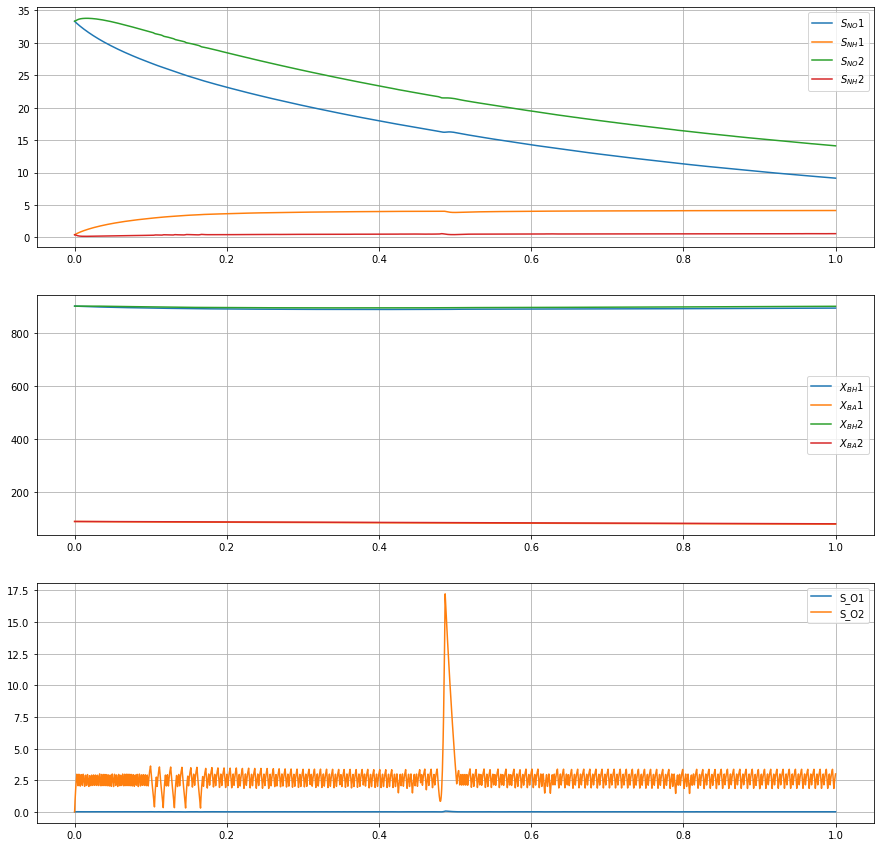

In [30]:
%reset -f

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


constate = 0
global constate

def asm1_2_comp(t,y):
    global constate 

    # Define number of compartments
    n = 2

    # indexes i=states, j=procs, k=compartment

    # Define state variables
    #                           0  1  2  3  4   5   6  7  8   9   10  11  12
    # state vector in order is: Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    
    # set up a vector shaped 13 (states) by n (compartments) 
    # this loops through the compartments to bulid the yv vector   
    yv = np.zeros((13,n))
    for k in range(n):
        ycurr=y[13*k:(k+1)*13]
        yv[:,k]=ycurr
    
    #Mean influent concentrations of components
    #      Si  Ss  Xi   Xs Xbh   Xba  Xp So Sno Snh   Snd   Xnd   Salk
    yin = [40, 64, 40, 160, 96, 0.001, 0, 0, 1, 12.5, 10.1, 18.28, 6]

    #Plant defintion and operational parameters
    V       = [50,30]          # volume (m3)
    qin     = 100              # influent flow rate (m3/d)
    qr      = 5*qin            # internal recycle
    qs      = qin              # clarifier underflow
    qw      = qin/20            # sludge wasteage flow
    qout    = qin-qw           # final outflow
    Xout    = 10               # final concentration solids

    #%% Parameters
    Ya  = 0.24                 # yield autotrophs
    Yh  = 0.67                 # yield heterotrophs
    fp  = 0.08                 # biomass to particulate products
    ixb = 0.07                 # N in biomass
    ixp = 0.06                 # N in particulate from biomass
    # Heterotrophs & hydrolysis
    muh = 4
    Ks  = 20
    Koh = 0.2
    Kno = 0.5
    bh  = 0.5
    nug = 0.8
    nuh = 0.35
    kh  = 1.5
    Kx  = 0.02
    # Autotrophs & ammonification
    mua = 0.9
    Knh = 0.75
    Koa = 0.5
    ka  = 0.08
    ba  = 0.1
    # Oxygen transfer
    O_sat = 7

    DO_upper = 3
    DO_lower = 2
    DO = yv[7,1]

    if constate == 0:
        kLa2 = 0
        if DO < DO_lower:
            constate = 1
    else:
        kLa2 = 300
        if DO > DO_upper:
            constate = 0


    #%% Stoichiometry
    v = np.zeros((9,13))
    v[0,1]  = (-1/Yh)
    v[0,4]  = 1
    v[0,7]  = -(1-Yh)/Yh       # Add DO coefficent for Hererotrophic growth
    v[0,9] = -ixb
    v[0,12] = (-ixb/14)

    v[1,1]  = (-1/Yh)
    v[1,4]  = 1
    v[1,8]  = (-(1-Yh)/(2.86*Yh))
    v[1,9] = -ixb
    v[1,12] = (((1-Yh)/(14*2.86*Yh))-ixb/14)

    v[2,5]  = 1    
    v[2,7]  = -(4.57-Ya)/Ya    # Add DO coefficent for Autotrophic growth
    v[2,8]  = 1/Ya
    v[2,9] = -ixb-1/Ya
    v[2,12] = (-ixb/14-1/(7*Ya))

    v[3,3]  = 1-fp
    v[3,4]  = -1
    v[3,6]  = fp
    v[3,11] = ixb-fp*ixp

    v[4,3]  = 1-fp
    v[4,5]  = -1
    v[4,6]  = fp
    v[4,11] = ixb-fp*ixp

    v[5,9] = 1
    v[5,10] = -1
    v[5,12] = 1/14

    v[6,1]  = 1
    v[6,3]  = -1

    v[7,10] = 1
    v[7,11] = -1
    
    v[8,7]  = 1                # Add Coeff for aeration

    
    #%% Process rates (constitutive equations)
    #    Si; Ss; Xi; Xs; Xbh; Xba; Xp ;So;Sno ;Snh;Snd; Xnd;Salk
    #    0   1   2   3   4    5    6   7   8   9   10    11  12 
    r=np.zeros((9,n))
    for i in range(n):
        r[0,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(yv[7,i]/(Koh+yv[7,i]))*yv[4,i]
        r[1,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+(yv[8,i])))*nug*yv[4,i]
        r[2,i] = mua*(yv[9,i]/(Knh+yv[9,i]))*(yv[7,i]/(Koa+yv[7,i]))*yv[5,i]
        r[3,i] = bh*yv[4,i]
        r[4,i] = ba*yv[5,i]
        r[5,i] = ka*yv[10,i]*yv[4,i]
        r[6,i] = kh*((yv[3,i]/yv[4,i])/(Kx+(yv[3,i]/yv[4,i])))*((yv[7,i]/(Koh+yv[7,i])) \
            +nuh*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+yv[8,i])))*yv[4,i]
        r[7,i] = r[6,i]*(yv[11,i]/yv[3,i])

    # set areation for comparment 2
    r[8,0] = 0  
    r[8,1] = kLa2*(O_sat-yv[7,1])  
    
    
    # Calculate clarifier capture 
    TS_end  = sum(yv[2:6,-1])
    qclar   = qin+qs-qw
    clarcap = 1-Xout*qout/(qclar*TS_end)
        
    # Calculate concentrations in sludge
    ys     = np.copy(yv[:,-1])         #initially set it to solubles
    ys[2]  = yv[2,-1] *(qin+qs-qw)/qs*clarcap
    ys[3]  = yv[3,-1] *(qin+qs-qw)/qs*clarcap
    ys[4]  = yv[4,-1] *(qin+qs-qw)/qs*clarcap
    ys[5]  = yv[5,-1] *(qin+qs-qw)/qs*clarcap
    ys[6]  = yv[6,-1] *(qin+qs-qw)/qs*clarcap
    ys[11] = yv[11,-1]*(qin+qs-qw)/qs*clarcap
    
    #%% Mass balances in steady state (conservative equations)
    #    Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    #    0  1  2  3   4  5   6  7   8   9  10  11   12 
    # First compartment
    dydtv = np.zeros((13,n))
    for i in range(13):
        dydtv[i,0] = 1/V[0]*(qin*(yin[i]-yv[i,0]) \
                    + qr*(yv[i,-1]-yv[i,0]) \
                    + (qs-qw)*(ys[i]-yv[i,0])) \
                    + np.matmul(r[:,0],v[:,i])

    # Remaining compartments
    if n>1:
        for k in range(1,n):
            for i in range(13):
                dydtv[i,k] = 1/V[k]*((qin+qr+qs-qw)*(yv[i,k-1]-yv[i,k])) \
                    +np.matmul(r[:,k],v[:,i])

    # Demultiplex
    dydt=np.zeros_like(y)
    for k in range(n):
        dydtcurr = dydtv[:,k]
        dydt[k*13:13*(k+1)] = dydtcurr
    return dydt

# Initial conditions for states
Si0   = 40                  # soluble inerts (mg/L)
Ss0   = 2.62                # soluble (readily biodegradable) COD (mg/L)
Xi0   = 1000                # particulate inerts (mg/L)
Xs0   = 29.46               # particulate (slowly biodegradable) COD (mg/L)
Xbh0  = 900                 # active heterotrophic biomass (mg/L)
Xba0  = 90.39               # active autotrophic biomass (mg/L)
Xp0   = 100.08              # particulate COD from decay (mg/L)
So0   = 0
Sno0  = 33.31               # nitrate-N + nitrite-N (mg/L)
Snh0  = 0.41                # ammonia-N (mg/L)
Snd0  = 0.93                # soluble (readily biodegradable) organic nitrogen (mg/L)
Xnd0  = 2.54                # particulate (slowly biodegradable) organic nitrogen (mg/L)
Salk0 = 22.83               # alkalinity (M)

y0 = np.array([Si0,Ss0,Xi0,Xs0,Xbh0,Xba0,Xp0,So0,Sno0,Snh0,Snd0,Xnd0,Salk0])
y0 = np.hstack([y0,y0])
tspan = (0,1)


sol=solve_ivp(asm1_2_comp,tspan,y0,method='LSODA',)

fig,ax = plt.subplots(3,1,figsize=(15, 15))
ax[0].plot(sol.t,sol.y[8,:],sol.t,sol.y[9,:],
        sol.t,sol.y[21,:],sol.t,sol.y[22,:])
ax[0].grid() 
ax[0].legend(('$S_{NO}1$','$S_{NH}1$','$S_{NO}2$','$S_{NH}2$'))
ax[1].plot(sol.t,sol.y[4,:],sol.t,sol.y[5,:],
        sol.t,sol.y[17,:],sol.t,sol.y[18,:])
ax[1].legend(('$X_{BH}1$','$X_{BA}1$','$X_{BH}2$','$X_{BA}2$'))
ax[1].grid() 
ax[2].plot(sol.t, sol.y[7,:], sol.t, sol.y[20,:])
ax[2].legend(('S_O1','S_O2'))
ax[2].grid() 

(d) Try the on-off and PI controllers with the variable input flow and concentration. How
do they work? Does one work better than the other?


(e) Implement the BSM2 (5 stage activated system), proportioning your aerobic and anoxic
volumes:

Tank 1 = 25m3 (Anoxic)

Tank 2 = 25m3 (Anoxic)

Tank 3 = 10m3 (Aerobic)

Tank 4 = 10m3 (Aerobic)

Tank 5 = 10m3 (Aerobic)

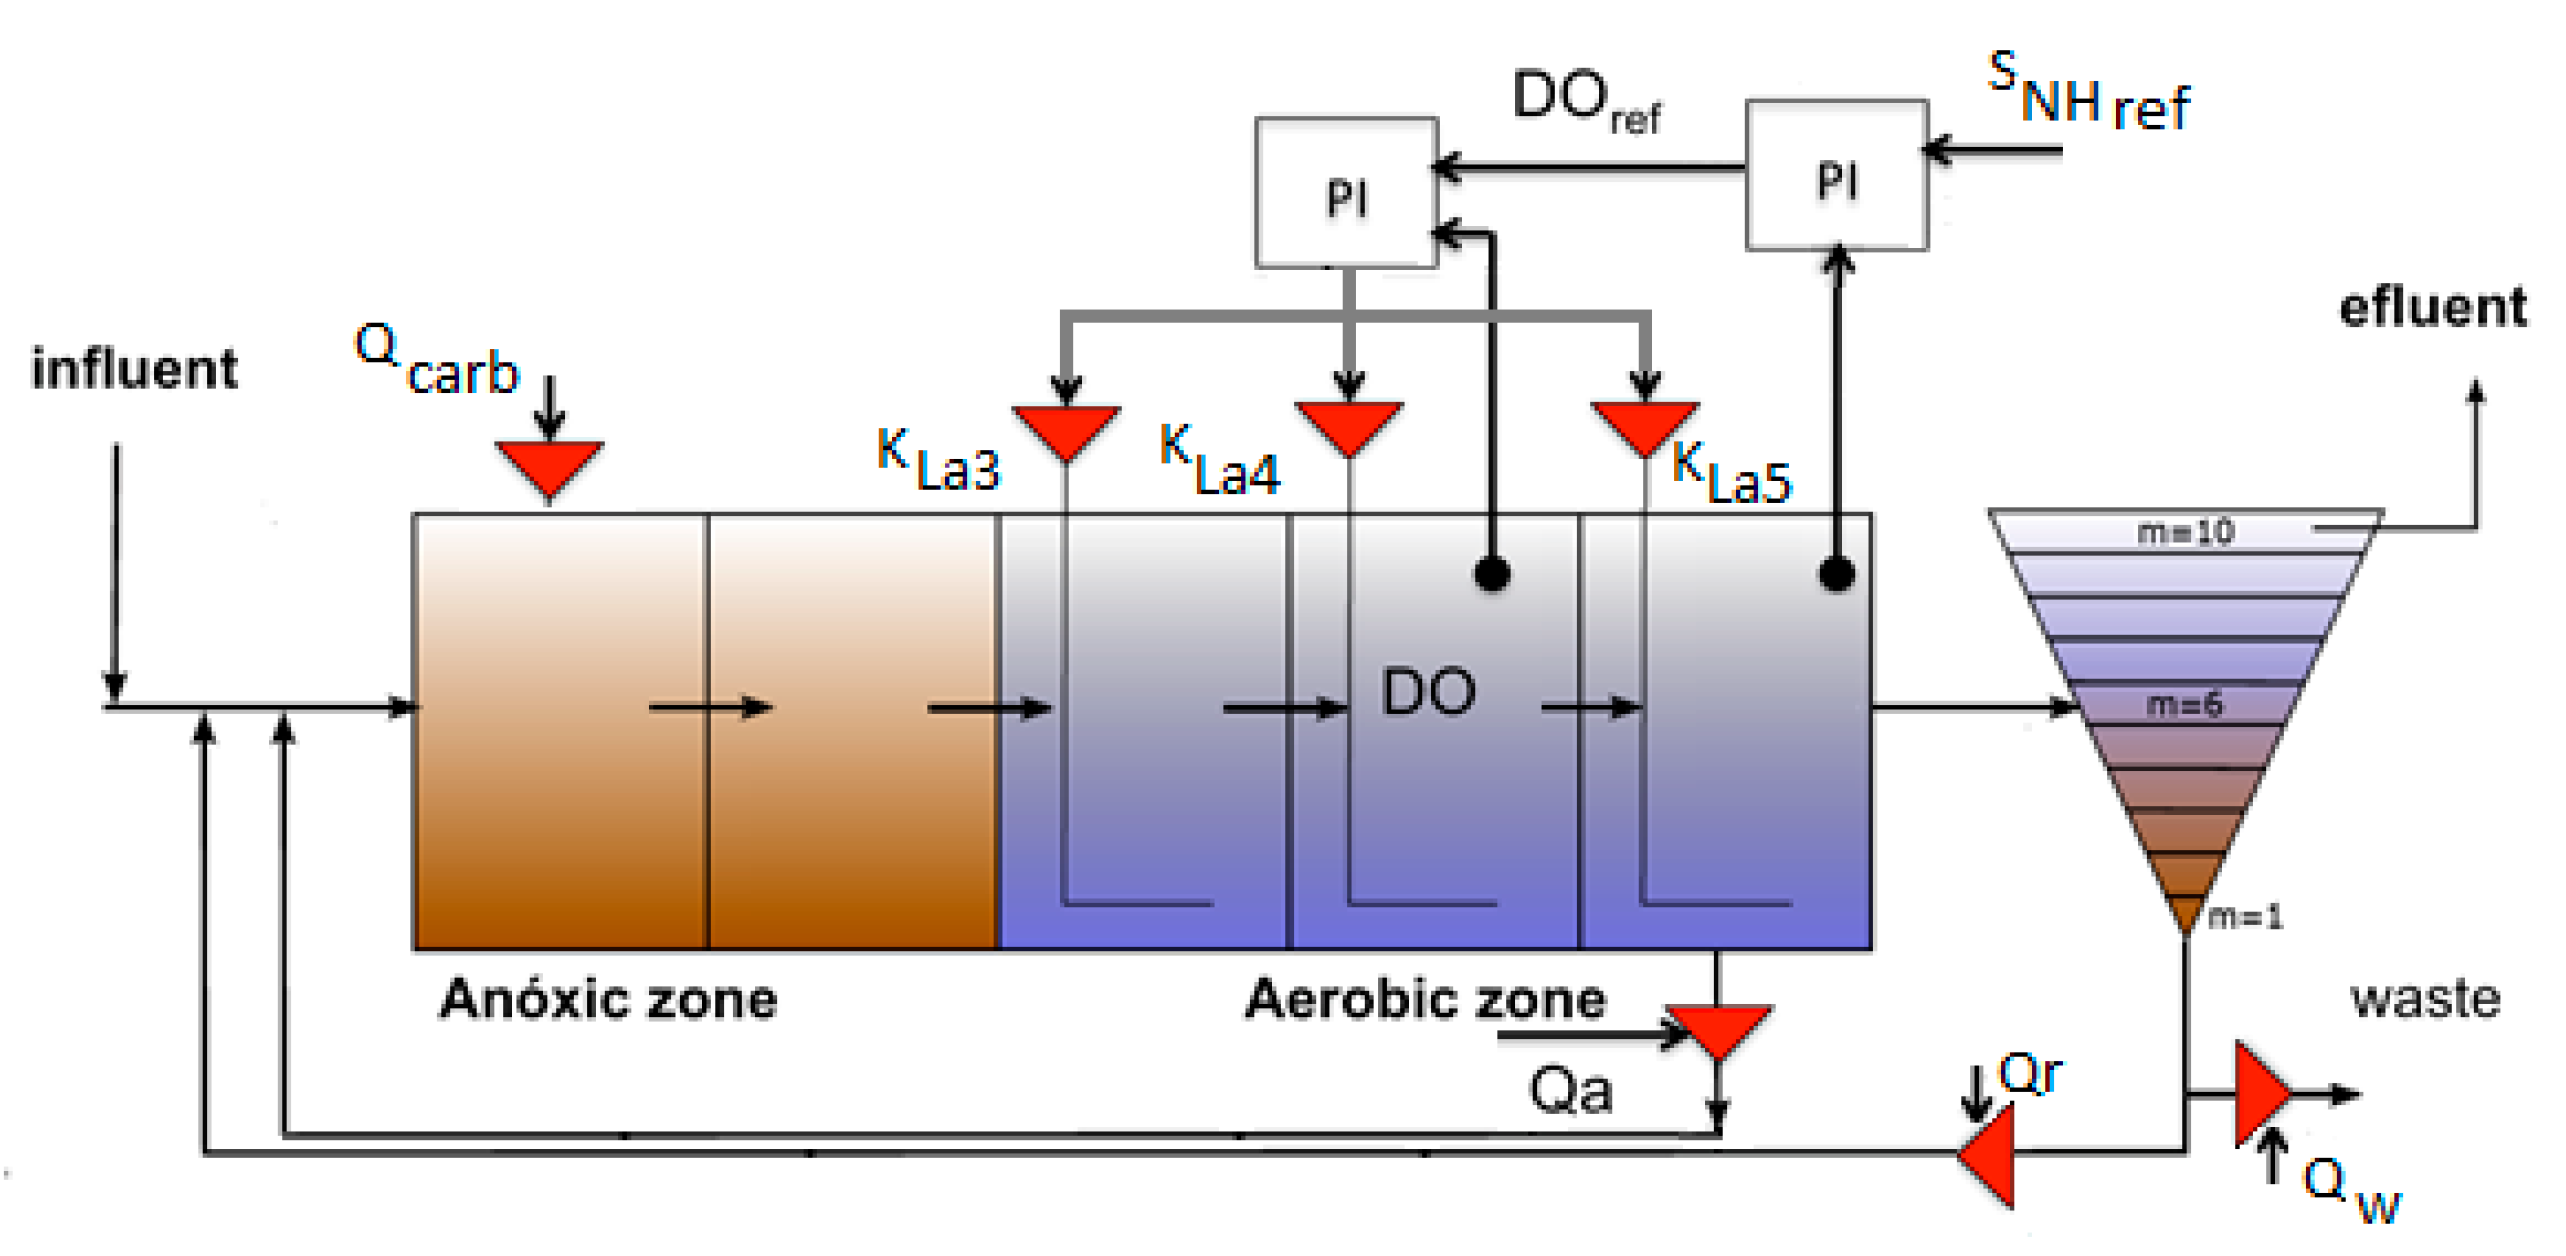

Only consider the 3 control loops for the 3 aerobic reactors for now. 

How does the performance with a DO controller (PI) at 2 mg/L on tanks 3-5 compare to the 2 stage system?

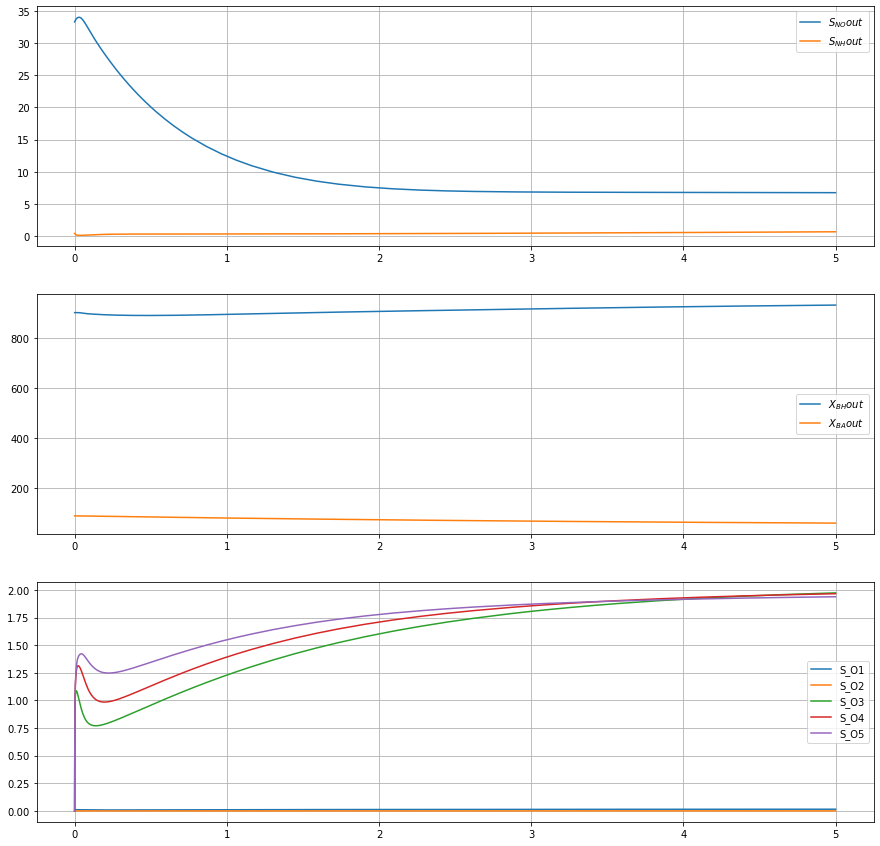

In [62]:
%reset -f

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def asm1_5_comp_PI(t,y):

    # Define number of compartments
    n = 5

    # indexes i=states, j=procs, k=compartment

    # Define state variables
    #                           0  1  2  3  4   5   6  7  8   9   10  11  12
    # state vector in order is: Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    
    # set up a vector shaped 13 (states) by n (compartments) 
    # this loops through the compartments to bulid the yv vector   
    yv = np.zeros((13,n))
    for k in range(n):
        ycurr=y[13*k:(k+1)*13]
        yv[:,k]=ycurr

    #Mean influent concentrations of components
    #      Si  Ss  Xi   Xs Xbh   Xba  Xp So Sno Snh   Snd   Xnd   Salk
    yin = [40, 64, 40, 160, 96, 0.001, 0, 0, 1, 12.5, 10.1, 18.28, 6]

    #Plant defintion and operational parameters
    V       = [25,25,10,10,10]          # volume (m3)
    qin     = 100              # influent flow rate (m3/d)
    qr      = 5*qin            # internal recycle
    qs      = qin              # clarifier underflow
    qw      = qin/20            # sludge wasteage flow
    qout    = qin-qw           # final outflow
    Xout    = 10               # final concentration solids

    #%% Parameters
    Ya  = 0.24                 # yield autotrophs
    Yh  = 0.67                 # yield heterotrophs
    fp  = 0.08                 # biomass to particulate products
    ixb = 0.07                 # N in biomass
    ixp = 0.06                 # N in particulate from biomass
    # Heterotrophs & hydrolysis
    muh = 4
    Ks  = 20
    Koh = 0.2
    Kno = 0.5
    bh  = 0.5
    nug = 0.8
    nuh = 0.35
    kh  = 1.5
    Kx  = 0.02
    # Autotrophs & ammonification
    mua = 0.9
    Knh = 0.75
    Koa = 0.5
    ka  = 0.08
    ba  = 0.1
    # Oxygen transfer
    O_sat = 7
    
    #%% Controls
    # Control for compartment 3
    DO_sp3 = 2
    kLa3 = 0
    error3 = DO_sp3-yv[7,2]
    kp3 = 100
    ki3 = 100
    if error3>0:
        kLa3= kp3*error3 + ki3 * y[13*n]
    # Control for compartment 4
    DO_sp4 = 2
    kLa4 = 0
    error4 = DO_sp4-yv[7,3]
    kp4 = 100
    ki4 = 100
    if error4>0:
        kLa4= kp4*error4 + ki4 * y[13*n+1]
    # Control for compartment 4
    DO_sp5 = 2
    kLa5 = 0
    error5 = DO_sp5-yv[7,4]
    kp5 = 100
    ki5 = 100
    if error5>0:
        kLa5= kp5*error5 + ki5 * y[13*n+2]

    #%% Stoichiometry
    v = np.zeros((9,13))
    v[0,1]  = (-1/Yh)
    v[0,4]  = 1
    v[0,7]  = -(1-Yh)/Yh       # Add DO coefficent for Hererotrophic growth
    v[0,9] = -ixb
    v[0,12] = (-ixb/14)

    v[1,1]  = (-1/Yh)
    v[1,4]  = 1
    v[1,8]  = (-(1-Yh)/(2.86*Yh))
    v[1,9] = -ixb
    v[1,12] = (((1-Yh)/(14*2.86*Yh))-ixb/14)

    v[2,5]  = 1    
    v[2,7]  = -(4.57-Ya)/Ya    # Add DO coefficent for Autotrophic growth
    v[2,8]  = 1/Ya
    v[2,9] = -ixb-1/Ya
    v[2,12] = (-ixb/14-1/(7*Ya))

    v[3,3]  = 1-fp
    v[3,4]  = -1
    v[3,6]  = fp
    v[3,11] = ixb-fp*ixp

    v[4,3]  = 1-fp
    v[4,5]  = -1
    v[4,6]  = fp
    v[4,11] = ixb-fp*ixp

    v[5,9] = 1
    v[5,10] = -1
    v[5,12] = 1/14

    v[6,1]  = 1
    v[6,3]  = -1

    v[7,10] = 1
    v[7,11] = -1
    
    v[8,7]  = 1                # Add Coeff for aeration

    
    #%% Process rates (constitutive equations)
    #    Si; Ss; Xi; Xs; Xbh; Xba; Xp ;So;Sno ;Snh;Snd; Xnd;Salk
    #    0   1   2   3   4    5    6   7   8   9   10    11  12 
    r=np.zeros((9,n))
    for i in range(n):
        r[0,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(yv[7,i]/(Koh+yv[7,i]))*yv[4,i]
        r[1,i] = muh*(yv[1,i]/(Ks+yv[1,i]))*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+(yv[8,i])))*nug*yv[4,i]
        r[2,i] = mua*(yv[9,i]/(Knh+yv[9,i]))*(yv[7,i]/(Koa+yv[7,i]))*yv[5,i]
        r[3,i] = bh*yv[4,i]
        r[4,i] = ba*yv[5,i]
        r[5,i] = ka*yv[10,i]*yv[4,i]
        r[6,i] = kh*((yv[3,i]/yv[4,i])/(Kx+(yv[3,i]/yv[4,i])))*((yv[7,i]/(Koh+yv[7,i])) \
            +nuh*(Koh/(Koh+yv[7,i]))*(yv[8,i]/(Kno+yv[8,i])))*yv[4,i]
        r[7,i] = r[6,i]*(yv[11,i]/yv[3,i])

    # set areation for comparment 3 to 5
    r[8,0] = 0  
    r[8,1] = 0  
    r[8,2] = kLa3*(O_sat-yv[7,2])  
    r[8,3] = kLa4*(O_sat-yv[7,3])  
    r[8,4] = kLa5*(O_sat-yv[7,4])  
    
    
    # Calculate clarifier capture 
    TS_end  = sum(yv[2:6,-1])
    qclar   = qin+qs-qw
    clarcap = 1-Xout*qout/(qclar*TS_end)
        
    # Calculate concentrations in sludge
    ys     = np.copy(yv[:,-1])         #initially set it to solubles
    ys[2]  = yv[2,-1] *(qin+qs-qw)/qs*clarcap
    ys[3]  = yv[3,-1] *(qin+qs-qw)/qs*clarcap
    ys[4]  = yv[4,-1] *(qin+qs-qw)/qs*clarcap
    ys[5]  = yv[5,-1] *(qin+qs-qw)/qs*clarcap
    ys[6]  = yv[6,-1] *(qin+qs-qw)/qs*clarcap
    ys[11] = yv[11,-1]*(qin+qs-qw)/qs*clarcap
    
    #%% Mass balances in steady state (conservative equations)
    #    Si Ss Xi Xs Xbh Xba Xp So Sno Snh Snd Xnd Salk
    #    0  1  2  3   4  5   6  7   8   9  10  11   12 
    # First compartment
    dydtv = np.zeros((13,n))
    for i in range(13):
        dydtv[i,0] = 1/V[0]*(qin*(yin[i]-yv[i,0]) \
                    + qr*(yv[i,-1]-yv[i,0]) \
                    + (qs-qw)*(ys[i]-yv[i,0])) \
                    + np.matmul(r[:,0],v[:,i])

    # Remaining compartments
    if n>1:
        for k in range(1,n):
            for i in range(13):
                
                dydtv[i,k] = 1/V[k]*((qin+qr+qs-qw)*(yv[i,k-1]-yv[i,k])) \
                    +np.matmul(r[:,k],v[:,i])


    # Demultiplex
    dydt=np.zeros_like(y)
    for k in range(n):
        dydtcurr = dydtv[:,k]
        dydt[k*13:13*(k+1)] = dydtcurr
    # store errors as states 
    dydt[13*n] = error3
    dydt[13*n+1] = error4
    dydt[13*n+2] = error5
    return dydt

# Initial conditions for states
Si0   = 40                  # soluble inerts (mg/L)
Ss0   = 2.62                # soluble (readily biodegradable) COD (mg/L)
Xi0   = 1000                # particulate inerts (mg/L)
Xs0   = 29.46               # particulate (slowly biodegradable) COD (mg/L)
Xbh0  = 900                 # active heterotrophic biomass (mg/L)
Xba0  = 90.39               # active autotrophic biomass (mg/L)
Xp0   = 100.08              # particulate COD from decay (mg/L)
So0   = 0
Sno0  = 33.31               # nitrate-N + nitrite-N (mg/L)
Snh0  = 0.41                # ammonia-N (mg/L)
Snd0  = 0.93                # soluble (readily biodegradable) organic nitrogen (mg/L)
Xnd0  = 2.54                # particulate (slowly biodegradable) organic nitrogen (mg/L)
Salk0 = 22.83               # alkalinity (M)

y0 = np.array([Si0,Ss0,Xi0,Xs0,Xbh0,Xba0,Xp0,So0,Sno0,Snh0,Snd0,Xnd0,Salk0])
y0 = np.hstack([y0,y0,y0,y0,y0,0,0,0])
tspan = (0,5)
sol=solve_ivp(asm1_5_comp_PI,tspan,y0,method='LSODA',)

fig,ax = plt.subplots(3,1,figsize=(15, 15))
ax[0].plot(sol.t,sol.y[8+13*4,:],sol.t,sol.y[9+13*4,:])
ax[0].grid() 
ax[0].legend(('$S_{NO}out$','$S_{NH}out$'))
ax[1].plot(sol.t,sol.y[4+13*4,:],sol.t,sol.y[5+13*4,:])
ax[1].legend(('$X_{BH}out$','$X_{BA}out$'))
ax[1].grid() 
ax[2].plot(sol.t, sol.y[7,:], sol.t, sol.y[20,:], sol.t, sol.y[33,:], sol.t, sol.y[46,:], sol.t, sol.y[59,:])
ax[2].legend(('S_O1','S_O2','S_O3','S_O4','S_O5'))
ax[2].grid() 